# Toxic Comment Classification


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import os
import sys
import re
from nltk.corpus import wordnet
import nltk
nltk.download('all')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, concatenate, Embedding, LSTM, Dropout, Input, Activation, RNN, Embedding, GRU
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /usr/share/nltk_data...


# Cleaning Utilities

In [2]:
# set of stop_words in english grammar
stop_words=set(stopwords.words('english'))
# lemmatize the words to their root/ synonym word which has meaning
lemmatizer=nltk.stem.WordNetLemmatizer()
tokenizer=TweetTokenizer()

# Removing Short-Hand Words

In [3]:
# Convert Most Commonly Used Short-Hand phrases
short_hands = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}

# Utility Function To Clean Comments

In [4]:
def clean_comment(comment):
     
    #removing \n,\\n,\t,\\ characters with space
    comment=comment.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    comment=re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' ', comment)
     
    #remove @usernames, @ip_address, @id_numbers
    comment=re.sub('\[\[.*\]', ' ', comment)
    
    # remove non-alphabetical characters
    comment=re.sub("\W+"," ",comment)
    
    # Remove all the occurrences of links that starts with https
    comment=re.sub(r'http\S+', '', comment)
    
    # Remove all the occurrences of text that ends with .com
    comment=re.sub(r"\ [A-Za-z]*\.com", " ",comment)
    
    # Remove all whitespaces
    pattern=re.compile(r'\s+') 
    comment= re.sub(pattern, ' ',comment)
    comment=comment.replace('?', ' ? ').replace(')', ') ')
    
    # Remove repeated characters/punctuation-marks
    # Pattern matching for all case alphabets
    pattern=re.compile(r"([A-Za-z])\1{1,}",re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    comment=pattern.sub(r"\1\1",comment) 
    
    # Pattern matching for all the punctuations that can occur
    pattern=re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    comment=pattern.sub(r'\1',comment)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    comment=re.sub(' {2,}',' ', comment)
    
    # Remove special characters
    comment=re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ',comment) 
    
    # converting each comment to lower case
    comment=comment.lower()
    
    # splitting comment into words
    words=tokenizer.tokenize(comment)
    
    # removing stop words
    words=[w for w in words if not w in stop_words]
    
    # removing the short_hands to their full forms
    words=[short_hands[word] if word in short_hands else word for word in words]
    
    words=[lemmatizer.lemmatize(w,"v") for w in words]
    
    return ' '.join(words)


# Reading Datasets


In [5]:
train=pd.read_csv('/kaggle/input/toxiccommentdata/train.csv')
submission=pd.read_csv('/kaggle/input/toxiccommentdata/sample_submission.csv')
test=pd.read_csv('/kaggle/input/toxiccommentdata/test.csv')

In [6]:
train.head(12)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
test.head(12)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


# Labels

In [8]:
target_labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
target_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [9]:
y_train = train[target_labels].values
y_train[1:10,:] #1st 10 examples

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [10]:
test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [11]:
train[:1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [12]:
test[:1]

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...


# Cleaning All the comments

In [13]:
train_cleaned=train['comment_text'].apply(lambda comment : clean_comment(comment))

In [14]:
train_cleaned.shape

(159571,)

In [15]:
train_cleaned.head(12)

0     explanation edit make username hardcore metall...
1     aww match background colour seemingly stick th...
2     hey man really try edit war guy constantly rem...
3     make real suggestions improvement wonder secti...
4                         sir hero chance remember page
5               congratulations well use tool well talk
6                           cocksucker piss around work
7     vandalism matt shirvington article revert plea...
8     sorry word nonsense offensive anyway intend wr...
9                  alignment subject contrary dulithgow
10    fair use rationale image wonju jpg thank uploa...
11                      bbq man let discuss maybe phone
Name: comment_text, dtype: object

In [16]:
test_cleaned=test['comment_text'].apply(lambda comment : clean_comment(comment)) 

In [17]:
test_cleaned.shape

(153164,)

In [18]:
test_cleaned.head(12)

0     yo bitch ja rule succesful ever whats hat sad ...
1                                    rfc title fine imo
2                            source zawe ashton lapland
3     look back source information update correct fo...
4                              anonymously edit article
5     thank understand think highly would revert wit...
6     please add nonsense wikipedia edit consider va...
7                                dear god site horrible
8     fool believe number correct number lie ponder ...
9     double redirect fix double redirect blank oute...
10    think crap link roggenbier article somebody kn...
11    somebody invariably try add religion really me...
Name: comment_text, dtype: object

# Saving Cleaned Comments as CSV for later Use

In [19]:
train_clean_df = pd.DataFrame(train_cleaned)
train_clean_df.to_csv('train_cleaned.csv')
test_clean_df = pd.DataFrame(test_cleaned)
test_clean_df.to_csv('test_cleaned.csv')

# Hyperparameters

In [20]:
vocab_size=100000
embed_size=300

# Tokenize Comments

In [21]:
tokenizer=Tokenizer(vocab_size)
tokenizer.fit_on_texts(list(train_cleaned))
tokenized_train=tokenizer.texts_to_sequences(train_cleaned)
tokenizer_test=tokenizer.texts_to_sequences(test_cleaned)

In [22]:
train_cleaned[0]

'explanation edit make username hardcore metallica fan revert vandalisms closure gas vote new york dolls fac please remove template talk page since retire'

In [23]:
tokenized_train[0]

[539,
 4,
 7,
 528,
 3531,
 8958,
 593,
 64,
 9102,
 5007,
 1952,
 415,
 59,
 1001,
 12115,
 2242,
 8,
 35,
 253,
 5,
 2,
 78,
 2046]

# Distribution of Comment Lengths

mean	 34.30768122027185
std dev	 53.5793531405591


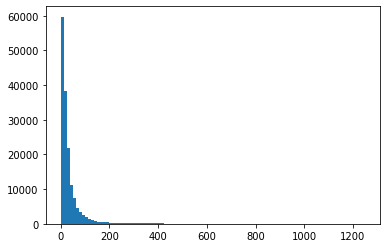

In [24]:
result = [len(x) for x in tokenized_train]
print("mean\t",np.mean(result))
print("std dev\t", np.std(result))
plt.hist(result,bins = 100)
plt.show()

# Model Hyperparameters

In [25]:
# Since almost all of the comments have length<=150 words
max_len=140
embed_size=300
batch_size=32
epochs=3

In [26]:
x_train = pad_sequences(tokenized_train, maxlen = max_len)
x_test = pad_sequences(tokenizer_test, maxlen = max_len)

# Model Configuration

In [27]:
inputs=Input(shape=(max_len, ))

x = Embedding(vocab_size, embed_size)(inputs)
out_dim = 128

x = Bidirectional(GRU(out_dim, return_sequences = True, dropout=0.25, recurrent_dropout=0.25))(x)

globalAveragePool = GlobalAveragePooling1D()(x)
globalMaxPool = GlobalMaxPooling1D()(x)

x=concatenate([globalAveragePool,globalMaxPool])

x = Dropout(0.15)(x)
x = Dense(6,activation = 'sigmoid')(x)

model=Model(inputs = inputs, outputs = x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

2022-11-28 13:15:19.148221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 13:15:19.149191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 13:15:19.329497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 13:15:19.330341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 13:15:19.331136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

# Callbacks and ModelCheckPoints

In [28]:
checkpoint=ModelCheckpoint('toxic-comment-classifier.hdf5',monitor='val_acc',verbose=1,save_best_only=True, mode='max')
earlyStopper=EarlyStopping(monitor='val_acc',mode='max',patience=2)
callbacks=[checkpoint,earlyStopper]

# Traing The Network

In [29]:
model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,validation_split = 0.2,callbacks=callbacks)

2022-11-28 13:15:23.825360: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
3990/3990 [==============================] - 4363s 1s/step - loss: 0.0584 - accuracy: 0.9641 - val_loss: 0.0490 - val_accuracy: 0.9777
Epoch 2/3
3990/3990 [==============================] - 4319s 1s/step - loss: 0.0398 - accuracy: 0.9451 - val_loss: 0.0473 - val_accuracy: 0.9827
Epoch 3/3
3990/3990 [==============================] - 4333s 1s/step - loss: 0.0311 - accuracy: 0.8097 - val_loss: 0.0501 - val_accuracy: 0.7773


# Testing The Network

In [30]:
y_pred=model.predict(x_test,batch_size=1024)
submission[target_labels] = y_pred
submission.to_csv('predictions.csv',index=False)